# W3C prov based provenance storage in Neo4j

This notebook tries to provide a first simple mapping between a W3C prov standard based provenance description to a Neo4j graph representation.

The approach taken is as follows:
- W3C prov json formated document --> neo-prov-utils --> Neo4j graph
- example queries
- refinement and discussion of neo-prov-utils based on this notebook
- development of a neo-prov-utils python package to be included in provenance capture software
- example usage of package in ENES community provenance capture activities


### W3C prov standard and used w3c prov tool

- W3C prov documents overview: https://www.w3.org/TR/prov-overview/
- The python prov software library is used ( https://github.com/trungdong/prov ) supporting the W3C provenance data model and providing PROV-JSON and PROV-XML implementations.
- The PROV-JSON representation proposal is described in https://www.w3.org/Submission/2013/SUBM-prov-json-20130424/

In the following PROV-JSON documents are used as a compact way to 
- specify provenance records 
- exchange provenance info between client and server components

#### The generic W3C prov graph model

The generic prov graph model is based on:
- Nodes (Agent, Entity, Activity) connected by
- Edges (wasAttributedTo, wasDerivedFrom, wasGeneratedBy, used, wasAssociatedWith)

see the following grahical representatin (taken from https://www.w3.org/TR/prov-overview/)

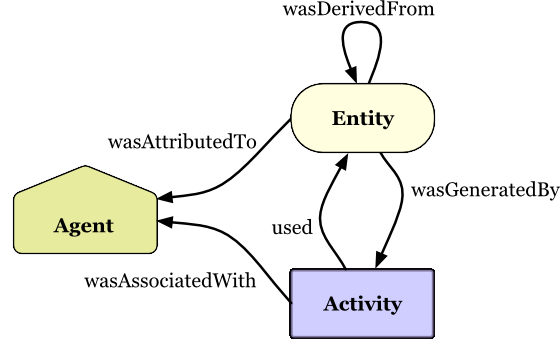

In [5]:
from IPython.display import display, Image
Image(filename='key-concepts.png')

## Example Prov-JSON export and import

In [12]:
from prov.model import ProvDocument
d1 = ProvDocument()

In [19]:
%%writefile wps-prov.json

{  
    "prefix": {
        "enes": "http://www.enes.org/enes_entitiy/", 
        "workflow": "http://www.enes.org/enes/workflow/#", 
        "dc": "http://dublin-core.org/", 
        "user": "http://www.enes.org/enes_entity/user/", 
        "file": "http://www.enes.org/enes_entity/file/", 
        "esgf": "http://carbon.dkrz.de/file/cmip5/", 
        "enes_data": "http://enes_org/enes_data#"
    },     
    "entity": { 
        "enes:input-data-set.nc": {
            "dc:title": "eval_series_1", 
            "prov:type": "Dataset", 
            "prov:label": "experiment-mpi-m"
            },  
        "enes:temporal-mean-result1-v1.nc": {
            "dc:title": "eval_series_1_1"
            } 
    },  
    "wasDerivedFrom": {
        "enes:process-step1": {
        "prov:usedEntity": "enes:input-data-set.nc", 
        "prov:generatedEntity": "enes:temporal-mean-result1-v1.nc"
        }
    },         
    "activity": {
        "workflow:temporal-mean-cdo": {
        }
    },       
    "used": {
    "enes:used-rel1": {
      "prov:entity": "enes:input-data-set.nc", 
      "prov:activity": "workflow:temporal-mean-cdo"
      }
    },
    "wasGeneratedBy": {
        "enes:gen-rel1": {
        "prov:entity": "enes:temporal-mean-result1-v1.nc", 
        "prov:activity": "workflow:temporal-mean-cdo"
      }
    },
    "agent": {
        "enes:Stephan Kindermann": {}
    }, 
    "wasAttributedTo": {
        "enes:data-generator-rel1": {
        "prov:entity": "enes:temporal-mean-result1-v1.nc", 
        "prov:agent": "enes:Stephan Kindermann"
      }
    }   
}

Overwriting wps-prov.json


In [20]:
d2 = ProvDocument.deserialize('wps-prov.json')

In [21]:
print d2.serialize(indent=2)

{
  "wasDerivedFrom": {
    "enes:process-step1": {
      "prov:usedEntity": "enes:input-data-set.nc", 
      "prov:generatedEntity": "enes:temporal-mean-result1-v1.nc"
    }
  }, 
  "used": {
    "enes:used-rel1": {
      "prov:entity": "enes:input-data-set.nc", 
      "prov:activity": "workflow:temporal-mean-cdo"
    }
  }, 
  "wasAttributedTo": {
    "enes:data-generator-rel1": {
      "prov:entity": "enes:temporal-mean-result1-v1.nc", 
      "prov:agent": "enes:Stephan Kindermann"
    }
  }, 
  "agent": {
    "enes:Stephan Kindermann": {}
  }, 
  "entity": {
    "enes:temporal-mean-result1-v1.nc": {
      "dc:title": "eval_series_1_1"
    }, 
    "enes:input-data-set.nc": {
      "dc:title": "eval_series_1", 
      "prov:type": "Dataset", 
      "prov:label": "experiment-mpi-m"
    }
  }, 
  "prefix": {
    "enes": "http://www.enes.org/enes_entitiy/", 
    "workflow": "http://www.enes.org/enes/workflow/#", 
    "dc": "http://dublin-core.org/", 
    "user": "http://www.enes.org/enes

In [22]:
def visualize_prov(prov_doc):
    from prov.dot import prov_to_dot
    from IPython.display import Image
    dot = prov_to_dot(prov_doc)
    dot.write_png('tmp1.png')
    dot.write_pdf('tmp1.pdf')
    
    return Image('tmp1.png')

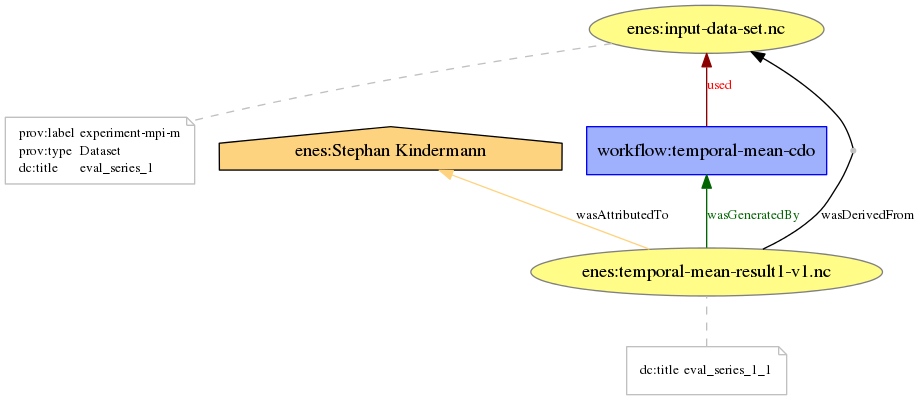

In [23]:
visualize_prov(d2)

## Example Transformation to Neo4j graph

to be finalized

In [36]:
der = d2.get_records()[0]
print der.get_type()
print der.attributes
print der.is_relation()
print der.label
print der.value
print der.args
print der.is_element()
print der.formal_attributes
print der.get_asserted_types()
print der.get_provn

prov:Derivation
[(<QualifiedName: prov:generatedEntity>, <QualifiedName: enes:temporal-mean-result1-v1.nc>), (<QualifiedName: prov:usedEntity>, <QualifiedName: enes:input-data-set.nc>)]
True
enes:process-step1
set([])
(<QualifiedName: enes:temporal-mean-result1-v1.nc>, <QualifiedName: enes:input-data-set.nc>, None, None, None)
False
((<QualifiedName: prov:generatedEntity>, <QualifiedName: enes:temporal-mean-result1-v1.nc>), (<QualifiedName: prov:usedEntity>, <QualifiedName: enes:input-data-set.nc>), (<QualifiedName: prov:activity>, None), (<QualifiedName: prov:generation>, None), (<QualifiedName: prov:usage>, None))
set([])
<bound method ProvDerivation.get_provn of <ProvDerivation: enes:process-step1 (enes:temporal-mean-result1-v1.nc, enes:input-data-set.nc)>>


In [5]:
agent = Node("Agent",name="WPS", service_url = "http://mouflon.dkrz.de")
entity = Node("Entity",name="a_b_c_d.nc", location = "/home/dkrz/cmip5")
activity = Node("Activity",name="flying-pigean/temporal_mean")

wasAttributedTo = Relationship(agent,"wasAttributedTo",entity)
wasAssociatedWith = Relationship(activity,"wasAssociatedWith",agent)
wasDerivedFrom = Relationship(entity,"wasDerivedFrom",entitiy)
wasGeneratedBy = Relationship(entity,"wasGeneratedBy",activity)
used = Relationship(activity,"used",entity)

In [3]:
from py2neo import Graph, Node, Relationship, authenticate
authenticate("localhost:7474", "neo4j", "prolog16")

# connect to authenticated graph database
graph = Graph("http://localhost:7474/db/data/")

In [6]:
graph.create(wasAttributedTo)

In [7]:
graph.create(wasAssociatedWith)
graph.create(wasDerivedFrom)
graph.create(wasGeneratedBy)
graph.create(used)